In [ ]:
!pip install scvi-tools
!pip install scanpy

In [1]:
!pip install anndata
import anndata as ad

In [2]:
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from scvi.external import RNAStereoscope, SpatialStereoscope

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import pandas as pd
path = './gdrive/MyDrive/ST_Project/MouseBrainData/'
Ann = sc.read_h5ad(path + 'all_cells_20200625.h5ad')
annotations = pd.read_csv(path + 'snRNA_annotation_astro_subtypes_refined59_20200823.csv')

spatial_data_path = path + "/filtered_feature_bc_matrix.h5"
Ann_spatial = sc.read_10x_h5(spatial_data_path, genome=None, gex_only=True, backup_url=None)

In [6]:
to_be_removed=[]
for cell in Ann.obs_names:
  if annotations["Unnamed: 0"].isin([cell]).sum():
    continue
  else:
    to_be_removed.append(cell)
t=Ann.obs.drop(index for index in to_be_removed) 
Ann= Ann[Ann.obs["barcode"].isin(t["barcode"].to_list())]

In [7]:
sc_adata=ad.AnnData(Ann.X)
st_adata=ad.AnnData(Ann_spatial.X)

In [8]:
mta=annotations["annotation_1"].to_numpy()
sc_adata.obs["cell_type"]=mta


In [9]:
sc_adata.layers["counts"] = sc_adata.X.copy()
RNAStereoscope.setup_anndata(sc_adata, layer = "counts", labels_key = "cell_type")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [37:32<00:00, 22.53s/it, loss=8.11e+05, v_num=1]


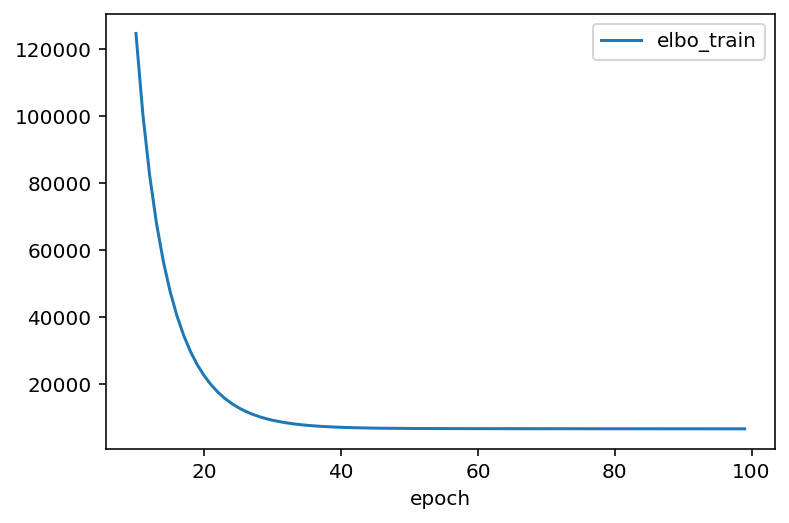

In [10]:
train = True
if train:
    sc_model = RNAStereoscope(sc_adata)
    sc_model.train(max_epochs = 100)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", adata=sc_adata)
    print("Loaded RNA model from file!")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2000/2000: 100%|██████████| 2000/2000 [31:11<00:00,  1.07it/s, loss=3.6e+07, v_num=1]


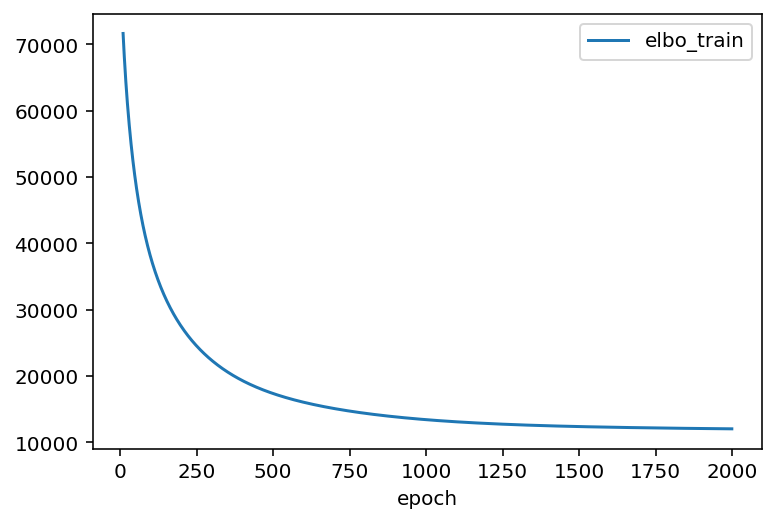

In [11]:
train=True
if train:
    spatial_model = SpatialStereoscope.from_rna_model(st_adata, sc_model)
    spatial_model.train(max_epochs = 2000)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", adata=st_adata)
    print("Loaded Spatial model from file!")

In [13]:
spatial_model.get_proportions().to_csv("output3.csv")

In [26]:
Ann

View of AnnData object with n_obs × n_vars = 40532 × 31053
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'